# Human Centered Data Science - A2 (Bias in data)

## Purpose of project: 

Purpose of this project is to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases. The data corpus that will be used for this project is called the Wikipedia Talk corpus, and it consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy. Google data scientists used these annotated datasets to train machine learning models as part of a project called Conversation AI. The models have been used in a variety of software products and made freely accessible to anyone through the Perspective API. 

## Motivation for the Analysis:

The goal of this assignment is to identify what, if any, sources of bias may exist in these datasets, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data, when those models are used for research purposes or to power data-driven applications.  By doing so I would like to demonstrate ability to perform a self-directed exploratory data analysis and think critically about the implications of findings.

Below are analysis questions of interest for me:

- Is labelling of content as aggressive or toxic and its severity varies by demographic profile of crowworkers (age group, gender, education etc)? 
- Are the set of annotation workers balanced demographically?
- Are the set of annotations balanced by worker demographics? 
- Which words are often associated with comments labelled as aggressive or toxic?

## Dataset:

To find answer to these questions, I will be using combination of below two datasets. Each of the question will refer both the datasets to find bias and any other meaningful information. 

[Toxicity Datasets](https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973)


[Agression Datasets](https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Aggression/4267550)

Terms of Use for these datasets are documented at [Wikimedia](https://foundation.wikimedia.org/wiki/Terms_of_Use/en) in detail.

 ### Import python libraries for analysis

In [1]:
import urllib.request
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import os
from functools import reduce
from datetime import datetime
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

## Step 1:  Data acquisition, cleaning and pre-processing

Let's first download the Wikipedia Talk label data files from website and save these to data folder for analysis. 

In [2]:
# Function to download data from website
def download_data(url,filename):
    response = urllib.request.urlretrieve(url, filename)
    return response

In [3]:
download_data('https://ndownloader.figshare.com/files/7394539', 'data/toxicity_annotations.tsv')
download_data('https://ndownloader.figshare.com/files/7394542', 'data/toxicity_annotated_comments.tsv')
download_data('https://ndownloader.figshare.com/files/7640581', 'data/toxicity_worker_demographics.tsv')
download_data('https://ndownloader.figshare.com/files/7394506', 'data/aggression_annotations.tsv')
download_data('https://ndownloader.figshare.com/files/7038038', 'data/aggression_annotated_comments.tsv')
download_data('https://ndownloader.figshare.com/files/7640644', 'data/aggression_worker_demographics.tsv')

('data/aggression_worker_demographics.tsv',
 <http.client.HTTPMessage at 0x7f9ae29d9a10>)

Further we read these files using pandas read_csv method and store it as dataframes. 

In [4]:
# Load data into dataframes
data_folder = 'data'
df_aggression_annotations = pd.read_csv(data_folder + '/' + "aggression_annotations.tsv", delimiter="\t")
df_aggression_worker_demographics =pd.read_csv(data_folder + '/' + "aggression_worker_demographics.tsv", delimiter="\t")
df_aggression_annotated_comments =pd.read_csv(data_folder + '/'+ "aggression_annotated_comments.tsv", delimiter="\t")
df_toxicity_annotations = pd.read_csv(data_folder + '/' + "toxicity_annotations.tsv", delimiter="\t")
df_toxicity_worker_demographics =pd.read_csv(data_folder + '/' + "toxicity_worker_demographics.tsv", delimiter="\t")
df_toxicity_annotated_comments =pd.read_csv(data_folder + '/'+ "toxicity_annotated_comments.tsv", delimiter="\t")

As part of data cleanup, let's remove Newline and Tabs from free text comment field. This helps in tokenization. 

In [5]:
df_aggression_annotated_comments['comment'] = df_aggression_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
df_aggression_annotated_comments['comment'] = df_aggression_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
df_aggression_annotated_comments.reset_index(inplace=True)
df_toxicity_annotated_comments['comment'] = df_toxicity_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
df_toxicity_annotated_comments['comment'] = df_toxicity_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
df_toxicity_annotated_comments.reset_index(inplace=True)

Now, let's join aggresssion and toxicity annoatation dataframes with respective worker dempgraphics dataframes to get complete picture for exploratory data analysis. 

In [6]:
df_aggression = pd.merge(df_aggression_annotations, df_aggression_worker_demographics, on='worker_id', how='left')
df_aggression = df_aggression.fillna("Unknown")
df_toxicity = pd.merge(df_toxicity_annotations, df_toxicity_worker_demographics, on='worker_id', how='left')
df_toxicity = df_toxicity.fillna("Unknown")

Let's understand combined aggression annotation and demographics dataframe to understand data model and data values in it at high level.

In [7]:
df_aggression.head(10)

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,male,0,18-30,masters
1,37675,2408,0.0,1.0,male,1,30-45,hs
2,37675,1493,0.0,0.0,female,0,30-45,bachelors
3,37675,1439,0.0,0.0,male,0,18-30,hs
4,37675,170,0.0,0.0,Unknown,Unknown,Unknown,Unknown
5,37675,176,0.0,0.0,male,0,18-30,hs
6,37675,481,0.0,0.0,female,0,18-30,hs
7,37675,487,0.0,0.0,female,0,18-30,masters
8,37675,578,0.0,0.0,female,0,30-45,hs
9,37675,1127,0.0,0.0,female,0,45-60,masters


Let's understand combined toxicity annotation and demographics dataframe to get flavor of data model and data values in it at high level.

In [8]:
df_toxicity.head(10)

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,female,0,30-45,bachelors
1,2232.0,4000,0,0.0,male,1,18-30,hs
2,2232.0,3989,0,1.0,female,0,18-30,bachelors
3,2232.0,3341,0,0.0,Unknown,Unknown,Unknown,Unknown
4,2232.0,1574,0,1.0,female,0,30-45,bachelors
5,2232.0,1508,0,1.0,female,1,45-60,hs
6,2232.0,772,0,1.0,male,0,18-30,bachelors
7,2232.0,680,0,0.0,male,0,18-30,masters
8,2232.0,405,0,1.0,male,0,30-45,masters
9,2232.0,4020,1,-1.0,male,0,30-45,hs


## Exploratory data analysis

Let's analyze aggression data with various demographic dimensions to see if bias exists in data in particular attribute of worker dempgraphics. 

### 1. Analyze if aggression score and toxic score has age group bias. 

For this, let's first compute mean aggression score and mean toxicity score and store values in respective demographics table.

In [9]:
df_aggression_worker_demographics["mean_aggression_score"] = df_aggression.groupby("worker_id")["aggression_score"].mean()
df_toxicity_worker_demographics["mean_toxicity_score"] = df_toxicity.groupby("worker_id")["toxicity_score"].mean()

Now, let's analyze analyze statistical mean aggression score by worker age group. 

In [10]:
df_aggression_worker_demographics.groupby("age_group").mean_aggression_score.mean()

age_group
18-30      -0.159801
30-45      -0.167509
45-60      -0.160936
Over 60    -0.082218
Under 18   -0.129005
Name: mean_aggression_score, dtype: float64

Also, let's visualize the distribution of workers mean aggression socre by age group to get better perspective of mean score distribution. 

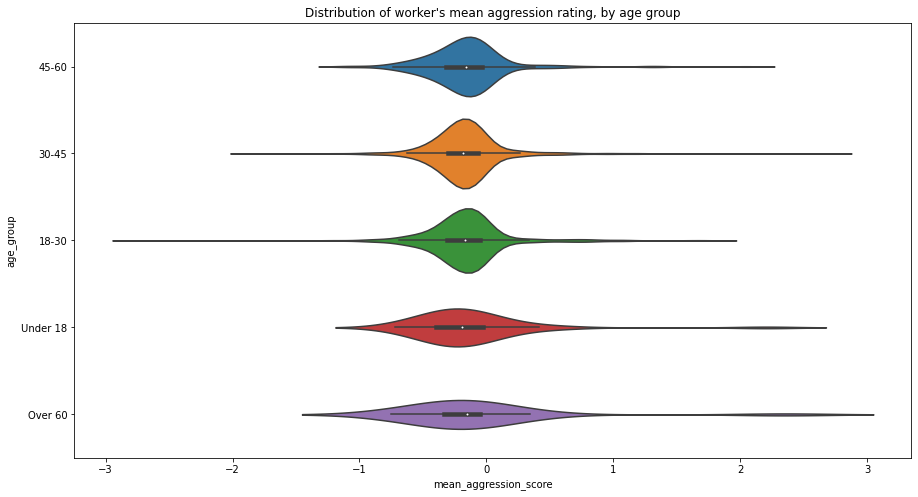

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean aggression rating, by age group")
sns.violinplot( x="mean_aggression_score", y="age_group", data= df_aggression_worker_demographics, ax=ax )
plt.savefig('plots/Distribution of workers mean aggression rating by age group.png')

#### As seen in above plots, it is clear than 'aggression bias' exist if analyzed by workers age group dimension. 

Now, let's analyze analyze mean toxicity score by worker age group. As seen below, there isn't much variation in toxicity score by age group. 

In [12]:
df_toxicity_worker_demographics.groupby("age_group").mean_toxicity_score.mean()

age_group
18-30       0.219225
30-45       0.204754
45-60       0.190176
Over 60     0.121644
Under 18    0.252275
Name: mean_toxicity_score, dtype: float64

Also, let's visualize the distribution of workers mean toxicity socre by age group to get better perspective of mean score distribution. 

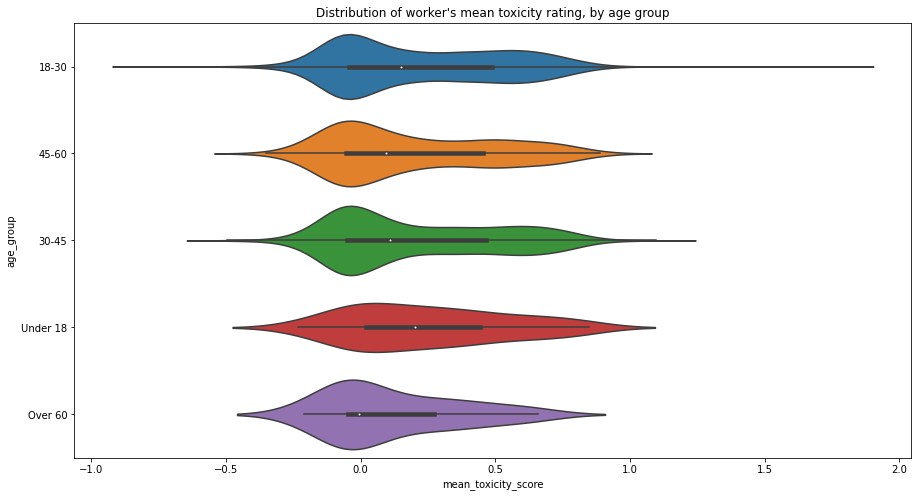

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="mean_toxicity_score", y="age_group", data= df_toxicity_worker_demographics, ax=ax )
plt.savefig('plots/Distribution of workers mean toxicity rating by age group.png')

#### As seen in above plots, it is clear than 'toxicity bias' exist if data is analyzed by workers age group dimension. 

### 2. Analyze if aggression score and toxic score has varied distribution by education (bias). 

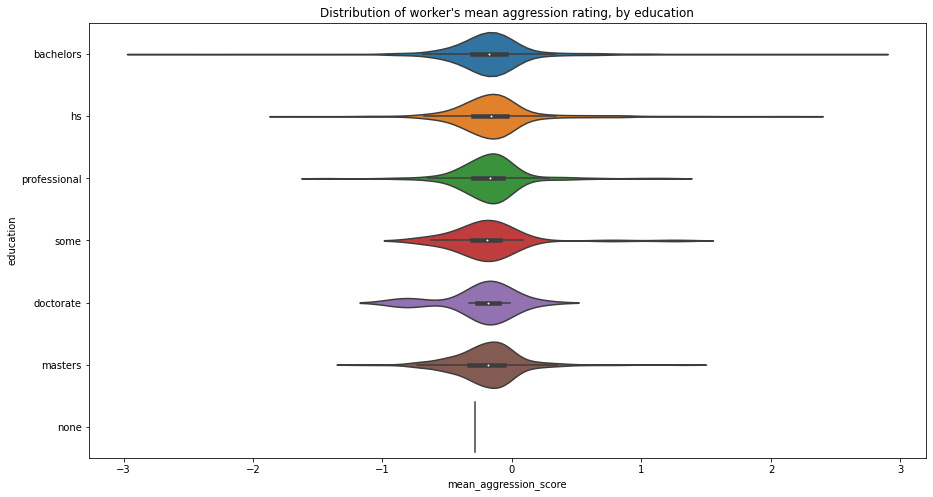

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean aggression rating, by education")
sns.violinplot( x="mean_aggression_score", y="education", data= df_aggression_worker_demographics, ax=ax )
plt.savefig('plots/Distribution of workers mean aggression rating by education.png')

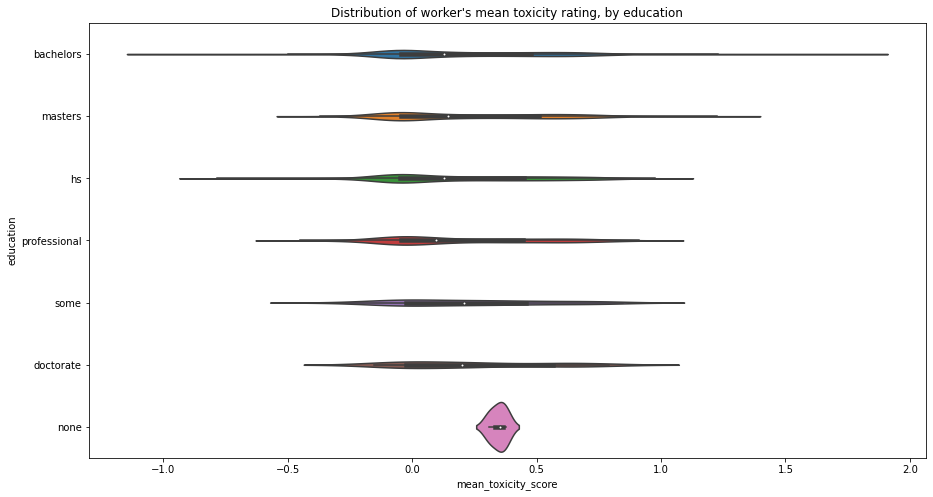

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by education")
sns.violinplot( x="mean_toxicity_score", y="education", data= df_toxicity_worker_demographics, ax=ax )
plt.savefig('plots/Distribution of workers mean toxicity rating by education.png')

#### As seen in above two plots, it is clear that  aggression score and toxic score gets biased by education profile of worker. Bachelors and Masters seems to rating the content aggressive and toxic at much higher level than others. 

### 3. Is the set of Aggression annotation workers balanced demographically? 

In [16]:
df_aggression_worker_demographics.groupby("gender").age_group.count()

gender
female     829
male      1325
other        1
Name: age_group, dtype: int64

In [17]:
df_aggression_worker_demographics.groupby("age_group").age_group.count()

age_group
18-30       1049
30-45        831
45-60        218
Over 60       20
Under 18      37
Name: age_group, dtype: int64

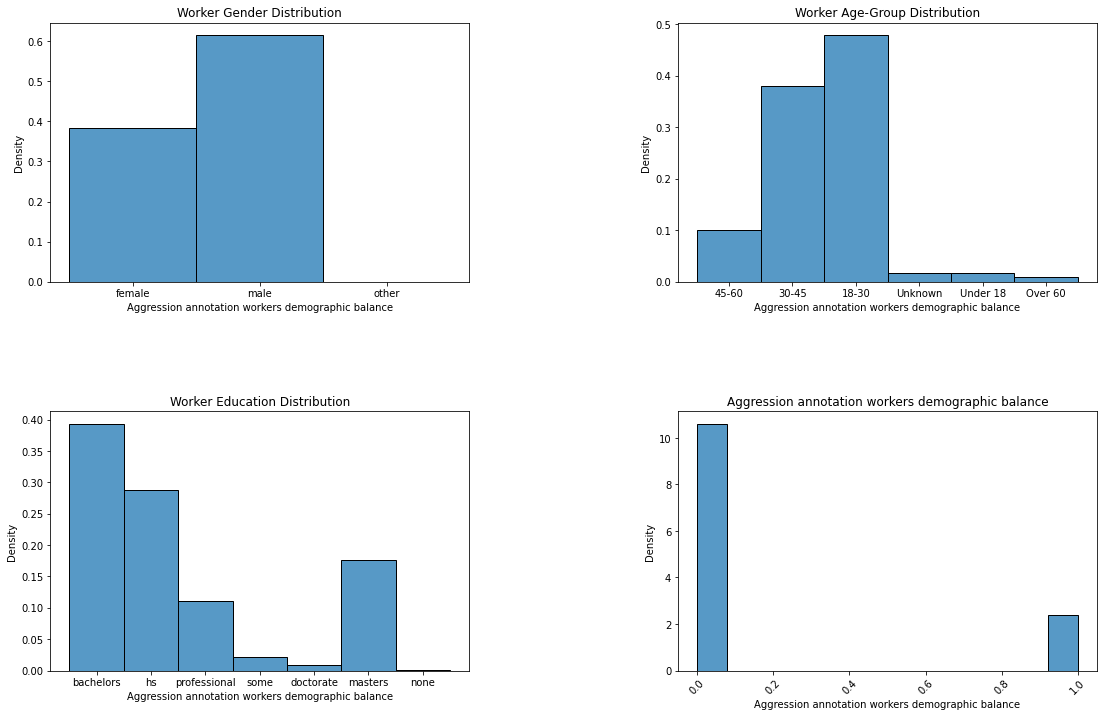

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout()
sns.histplot(df_aggression_worker_demographics, x='gender', ax=axs[0][0], 
             stat='density').set_title('Worker Gender Distribution')
sns.histplot(df_aggression_worker_demographics.fillna("Unknown"), x='age_group',\
             ax=axs[0][1], stat='density').set_title('Worker Age-Group Distribution')
sns.histplot(df_aggression_worker_demographics.fillna("Unknown"), x='education',  \
              ax=axs[1][0], stat='density').set_title('Worker Education Distribution')
sns.histplot(df_aggression_worker_demographics, x='english_first_language',             
             ax=axs[1][1], stat='density').set_title('Worker Native English Language Distribution')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
plt.title('Aggression annotation workers demographic balance')
plt.savefig('plots/Aggression annotation workers demographic balance.png')
for ax in axs.flatten():    
    ax.set_xlabel('Aggression annotation workers demographic balance')

#### As seen by above statistics and histogram plots the set of annotation workers are not balanced on any of the dempgraphic dimension. Using this  biased data in machine learning models will lead to inaccurate predictions and classifications. Before using this data in machine learning models we should minimzing the skwed data imbalance. 

### 4. Is the set of Aggression annotations balanced by workder demographics? 

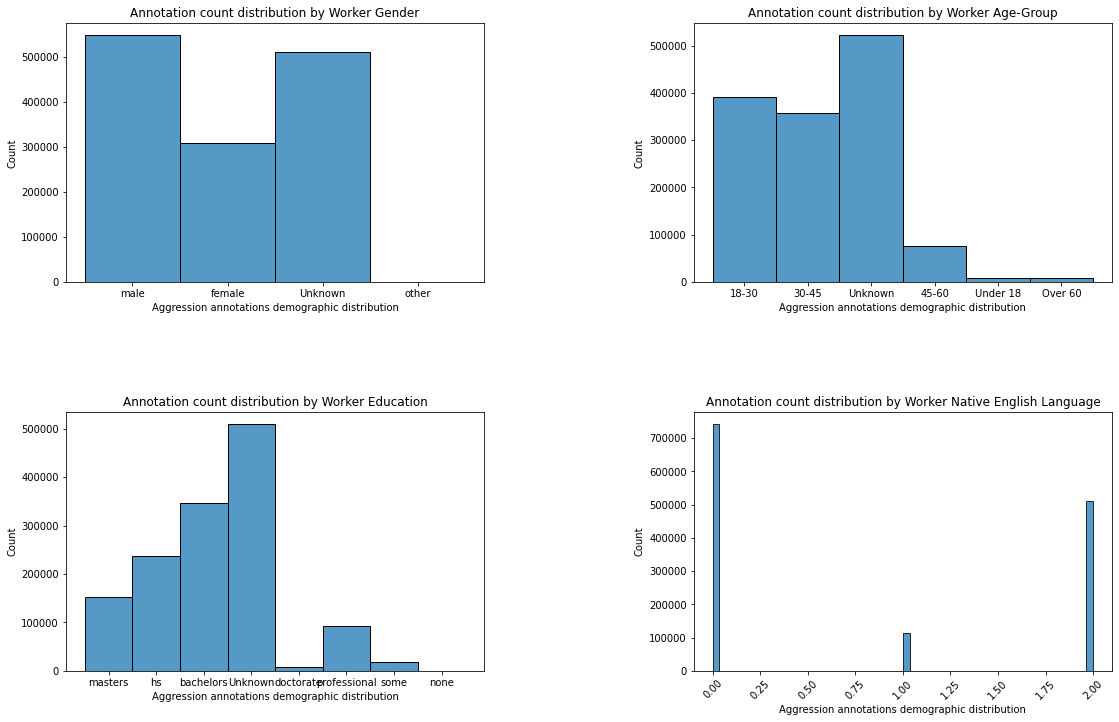

In [19]:
df_aggression.loc[df_aggression['english_first_language'] == 'Unknown', 'english_first_language'] = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout()
sns.histplot(df_aggression, x='gender', ax=axs[0][0], 
             stat='count').set_title('Annotation count distribution by Worker Gender')
sns.histplot(df_aggression, x='age_group', ax=axs[0][1], 
             stat='count').set_title('Annotation count distribution by Worker Age-Group')
sns.histplot(df_aggression, x='education', ax=axs[1][0], 
             stat='count').set_title('Annotation count distribution by Worker Education')
sns.histplot(df_aggression, x='english_first_language', ax=axs[1][1], 
             stat='count').set_title('Annotation count distribution by Worker Native English Language')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
plt.savefig('plots/Aggression annotations demographic distribution.png')
for ax in axs.flatten():    
    ax.set_xlabel('Aggression annotations demographic distribution')

#### As seen by above statistics and histogram plots the set of aggression annotations  are not balanced on any of the worker dempgraphic dimension. Using this  biased data in machine learning models will lead to inaccurate predictions and classifications. Before using this data in machine learning models we should minimzing the skwed data imbalance. 

### 5. Is the set of Toxicity annotation workers balanced demographically? 

In [20]:
df_toxicity_worker_demographics.groupby("gender").age_group.count()

gender
female    1234
male      2279
other        1
Name: age_group, dtype: int64

In [21]:
df_toxicity_worker_demographics.groupby("age_group").age_group.count()

age_group
18-30       1862
30-45       1247
45-60        296
Over 60       30
Under 18      79
Name: age_group, dtype: int64

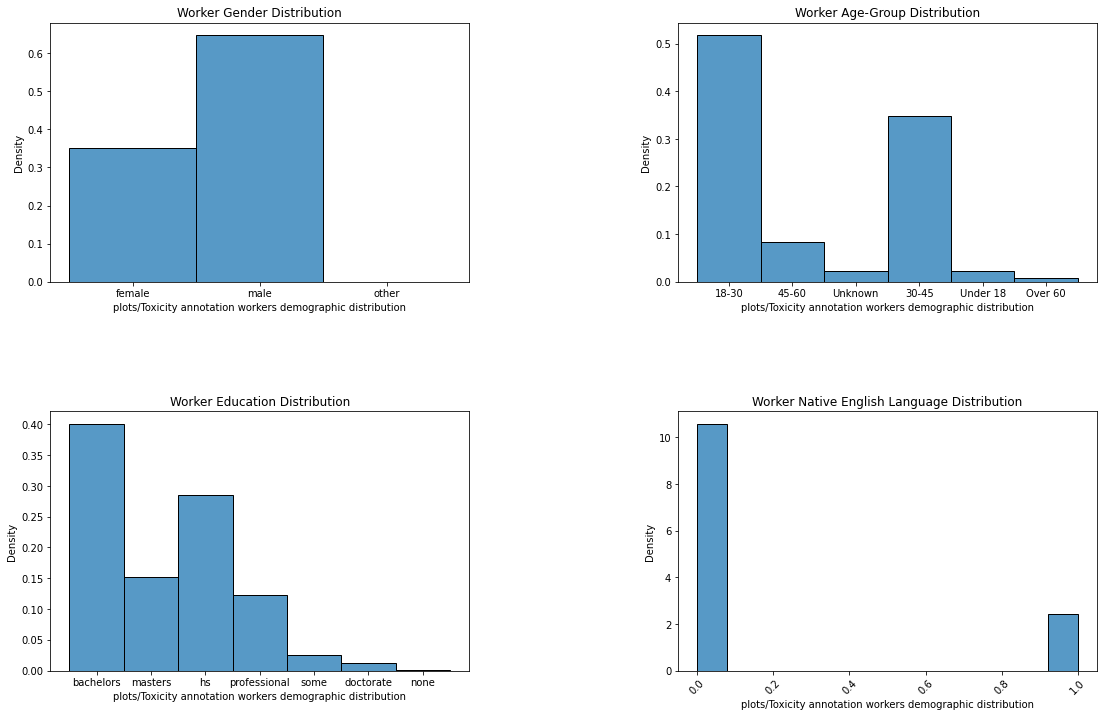

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout()
sns.histplot(df_toxicity_worker_demographics, x='gender', ax=axs[0][0], 
             stat='density').set_title('Worker Gender Distribution')
sns.histplot(df_toxicity_worker_demographics.fillna("Unknown"), x='age_group',\
             ax=axs[0][1], stat='density').set_title('Worker Age-Group Distribution')
sns.histplot(df_toxicity_worker_demographics.fillna("Unknown"), x='education',  \
              ax=axs[1][0], stat='density').set_title('Worker Education Distribution')
sns.histplot(df_toxicity_worker_demographics, x='english_first_language',             
             ax=axs[1][1], stat='density').set_title('Worker Native English Language Distribution')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
plt.savefig('Toxicity annotation workers demographic distribution.png')
for ax in axs.flatten():    
    ax.set_xlabel('plots/Toxicity annotation workers demographic distribution')

#### As seen by above statistics and histogram plots the set of annotation workers are not balanced on any of the dempgraphic dimension. Using this  biased data in machine learning models will lead to inaccurate predictions and classifications. Before using this data in machine learning models we should minimzing the skwed data imbalance. 

### 6. Is the set of Toxicity annotations balanced by worker demographics? 

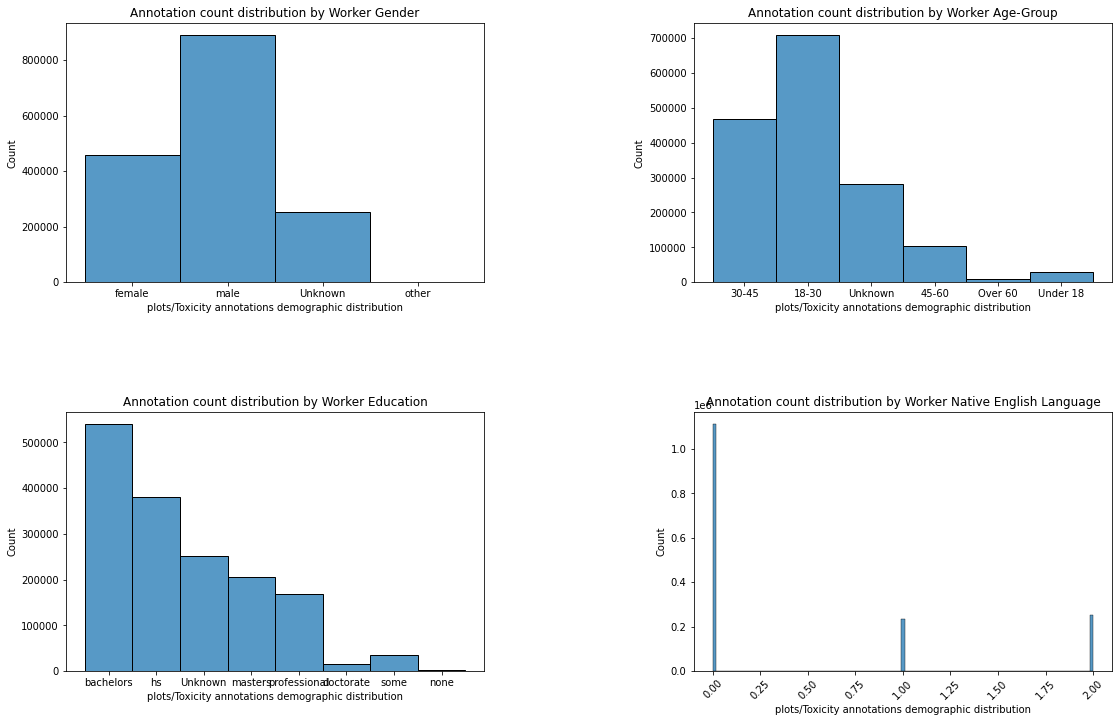

In [35]:
df_toxicity.loc[df_toxicity['english_first_language'] == 'Unknown', 'english_first_language'] = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout()
sns.histplot(df_toxicity, x='gender', ax=axs[0][0], 
             stat='count').set_title('Annotation count distribution by Worker Gender')
sns.histplot(df_toxicity, x='age_group', ax=axs[0][1], 
             stat='count').set_title('Annotation count distribution by Worker Age-Group')
sns.histplot(df_toxicity, x='education', ax=axs[1][0], 
             stat='count').set_title('Annotation count distribution by Worker Education')
sns.histplot(df_toxicity, x='english_first_language', ax=axs[1][1], 
             stat='count').set_title('Annotation count distribution by Worker Native English Language')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
plt.savefig('Toxicity annotations demographic distribution.png')
for ax in axs.flatten():    
    ax.set_xlabel('plots/Toxicity annotations demographic distribution')

#### As seen by above statistics and histogram plots the set of toxicity annotations  are not balanced on any of the worker dempgraphic dimension. Using this  biased data in machine learning models will lead to inaccurate predictions and classifications. Before using this data in machine learning models we should minimzing the skwed data imbalance. 

### 7. Are specific words more likely to be associated with comments labelled as Aggeressive or Toxic?

For this, first we will find toxic comment and then filter out the comments that are not labelled aggressive from it. We will then visualize Toxic but not aggressive comments using word cloud. 

In [24]:
# Let's first find the rev_id corresponding to toxic comments. 
# We will need to filter out toxic words based on toxicity value.

toxic_revid = df_toxicity_annotations.groupby("rev_id")["toxicity"].mean().reset_index()
toxic_revid =toxic_revid.loc[toxic_revid.toxicity ==1.0] 
toxic_revid.head(10)

,rev_id,toxicity
661,4632658.0,1.0
835,5861505.0,1.0
1063,7514418.0,1.0
1348,8845700.0,1.0
1349,8845736.0,1.0
1467,9392747.0,1.0
1527,9679297.0,1.0
1657,10266382.0,1.0
1659,10266890.0,1.0
1769,10693762.0,1.0


In [25]:
# Now let's find top toxic words that are not aggressive
aggression_annotations_filtered_by_toxic_revid = df_aggression_annotations.loc[(df_aggression_annotations.rev_id.isin(list(toxic_revid.rev_id.unique())))]
aggressive_revid = aggression_annotations_filtered_by_toxic_revid.groupby("rev_id")["aggression"].mean().reset_index()
aggressive_revid =aggressive_revid.loc[aggressive_revid.aggression <= 0.25].sort_values('aggression', ascending=True)
aggressive_revid.head(10)

,rev_id,aggression
337,59774584,0.100000
411,67477170,0.200000
523,79014905,0.200000
1381,193377429,0.200000
1469,201506910,0.200000
1583,213243866,0.200000
1673,222969625,0.200000
3130,443897669,0.200000
3779,618526723,0.200000
565,83816243,0.222222


In [26]:
# Now let's find the comments which were labelled as Toxic but not Aggressive
comments_toxic = df_aggression_annotated_comments.loc[df_aggression_annotated_comments.\
                                                      rev_id.isin(list(aggressive_revid.rev_id))]
comments_toxic.loc[~(comments_toxic.comment.str.contains('cunt', 'gay'))][['rev_id', 'comment']].head(10)

,rev_id,comment
13488,59774584,== Isn't that a bit lame? == Your just a mo...
16021,67477170,`horribly curse us Christians (...
20200,83816243,HOPE YOUR HEAD GETS CUT OFF AND SOMEONE WIPES...
42553,193377429,"that I am a big homo, and"
44500,201506910,Hey sceptre. How are you? Are you a virgin...
47142,213243866,"::::No it isn't, so if you wish to delete my ..."
49201,222969625,== Epic Fail == I am FREAKING SERIOUS!!! I...
84990,443897669,== Jose Baez == Well asshole! The article w...
98176,554382458,::::ONLY A NEONAZI QUACK WOULD INSIST ON AN A...
106302,618526723,ur a loser. i challenge u to block me. loser !!


Now, let's further visualize the Toxic words using word cloud.

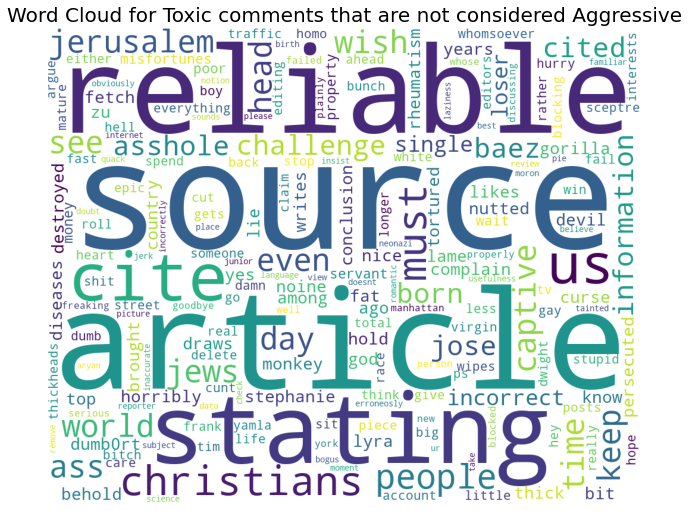

In [33]:
stopwords = ["that", "this", "now", "will", "one", "he", "she", "is", "hi"]  + list(STOPWORDS)
  
comment_words=''
for val in comments_toxic.comment: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()     
    comment_words += " ".join(tokens)+" "

# Let's prepare the word cloud and plot it
word_cloud = WordCloud(width = 1000, height = 800, background_color ='white', stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (15, 8)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 5)
plt.title('Word Cloud for Toxic comments that are not considered Aggressive', fontsize=20, color='black')
plt.savefig('plots/Word Cloud for Toxic comments that are not considered Aggressive.png')
plt.show()

### 8. Analyze the words that are considered as Aggressive but not Toxic

We will largely follow above described procedure here with appropriate change. For this, first we will find aggressive comments and then filter out the comments that are not labelled toxic. We will then visualize Aggressive but not Toxic comments using word cloud. 

In [28]:
# Let's first find the rev_id corresponding to aggressive comments. 
# We will need to filter out aggressive words based on aggression value.

aggression_revid = df_aggression_annotations.groupby("rev_id")["aggression"].mean().reset_index()
aggression_revid =aggression_revid.loc[aggression_revid.aggression == 1.0] 
aggression_revid.head(10)

,rev_id,aggression
207,2702703,1.0
492,6545332,1.0
701,8845736,1.0
774,9392747,1.0
803,9664254,1.0
899,10266382,1.0
900,10266787,1.0
1009,10949158,1.0
1010,10952727,1.0
1026,11121273,1.0


In [29]:
# Now let's find top aggresive words that are not considered toxic
toxicity_annotations_filtered_by_aggression_revid = df_toxicity_annotations.loc[(df_toxicity_annotations.rev_id.isin(list(aggression_revid.rev_id.unique())))]
toxicity_revid = toxicity_annotations_filtered_by_aggression_revid.groupby("rev_id")["toxicity"].mean().reset_index()
toxicity_revid =toxicity_revid.loc[toxicity_revid.toxicity <= 0.35].sort_values('toxicity', ascending=True)
toxicity_revid.head(10)

,rev_id,toxicity
325,66575394.0,0.300000
371,72479914.0,0.300000
554,98995159.0,0.300000
955,171967523.0,0.300000
1109,195215976.0,0.300000
1567,264065845.0,0.300000
2057,351641667.0,0.300000
3068,679832272.0,0.300000
2940,640135752.0,0.333333


In [30]:
# Now let's list the comments which were labelled as Aggressive but not Toxic
comments_aggression = df_toxicity_annotated_comments.loc[df_toxicity_annotated_comments.\
                                                      rev_id.isin(list(toxic_revid.rev_id))]
comments_aggression.loc[~(comments_aggression.comment.str.contains('dick', 'gay'))][['rev_id', 'comment']].head(10)

,rev_id,comment
835,5861505.0,==You're a motherfucking idiot== You're stu...
1063,7514418.0,a dippy lunatic like
1348,8845700.0,"i am using the sandbox, ass wipe"
1349,8845736.0,"== GOD DAMN == GOD DAMN it fuckers, i am us..."
1467,9392747.0,== WHY ARE YOU SUCH A GAY NIGGER?!?! == GOD...
1527,9679297.0,"== FUCK YOU THUE == YOU BRAIN DEAD FUCK, YO..."
1657,10266382.0,"LOL; charles, you are a real fag aren't you?..."
1659,10266890.0,"== SHUT UP, FAG == LOL YOU WILL BAN ME HUH?..."
1769,10693762.0,SLEEP WITH ME OR I WILL FUCKING KILL YOU AND B...
1809,10952824.0,"FUCK YOU ALKIVA wikipedia is a democracy, a w..."


Now, let's visualize Aggresive but Toxic words using word cloud. 

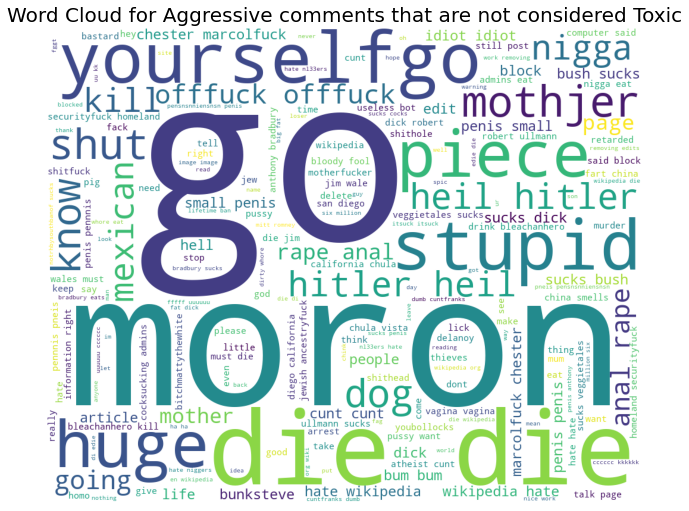

In [32]:
stopwords = ["that", "this", "now", "will", "one", "he", "she", "is", "hi", 'fuck', 'faggot', \
            'fucksex', 'Fucksex', 'fucking', 'nigger', 'shit', 'ass', 'bitch', 'cock', 'suck', 'asshole',\
            'bullshit', 'bitches', 'gay', 'fucker', 'fucker', 'cocksucker', 'dickhead'] + list(STOPWORDS)
  
comment_words=''
for val in comments_aggression.comment: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()     
    comment_words += " ".join(tokens)+" "

# Let's prepare the word cloud and plot it
word_cloud = WordCloud(width = 1000, height = 800, background_color ='white', stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (15, 8)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 5)
plt.title('Word Cloud for Aggressive comments that are not considered Toxic', fontsize=20, color='black')
plt.savefig('plots/Word Cloud for Aggressive comments that are not considered Toxic.png')
plt.show()

### Findings

We have discussed findings above in each section. Below is summary.
1. We found there is inherent participation bias in annotation worker population by different dempgraphic dimensions such as age_group, gender, eduation, english_first_language etc. 
2. We further found that the set of annotations both across aggression and toxicity has skewed distribution by various dempgraphic attributes. Hence both of these datasets has bias built in it. 
3. Before using this data in machine learning algorithms, appropriate steps should be taken to balance the dataset and to take into account population demographic imbalance. 

### Step 2: Discuss further implications

#### 1. Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

Ans: "Behave" application will work great on Perspective API—or any model trained on the Wikipedia Talk corpus. This app replaces toxic comments with emojis. For any application to perform well on Wikipedia Talk Corpus, it must have been trained on similar domain data and it should have taken steps to reduce bias in dataset. Behave applications seems to have addressed these issues. 


#### 2. What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?

Ans: or any application to perform well on Wikipedia Talk Corpus, it must have been trained on similar domain data and it should have taken steps to reduce bias in dataset. I beleive "WikiDetox" and "Toxicity Timeline" applications will perform particularly well as these are trained on same domain data and has addressed bias in data. 


#### 3. Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

Ans: As student of 'Human Centered Data Science' course, I would revise and apply the course concepts in developing new model or API. I will take into account worker participation bias and response bias and will use techniques to minimize the imbalance caused by bias. Further will use standard taxonomy and well defined, enriched stopwords to train the model. I will also factor in suggestions mentioned in  engadget.com article. Preserving the privacy and security of sensitive data will also one of the core responsibility in developing this API. 